In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasketch import MinHash, MinHashLSHForest
import time
import numpy as np


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

import warnings
warnings.filterwarnings('ignore')
plt.ticklabel_format(style='plain')
plt.ticklabel_format(style='plain', axis='x')
sns.set()


%matplotlib inline


Loading all data from files

In [2]:
df_google = pd.read_csv('../data/google_cleaned.csv',parse_dates=["Released","Updated"],index_col=[0])
df_apple = pd.read_csv('../data/apple_cleaned.csv',parse_dates=["Released","Updated"],index_col=[0])
df_match = pd.read_csv('../data/match_lsh.csv',index_col=[0])

Considering all matches with score of `0.2` as matched apps

In [14]:
df_match.loc[(df_match["score"] > 0.2)]

,apple_id,android_id,score
0,com.hkbu.arc.apaper,com.hkbu.arc.apaper,0.733333
4,com.imonstersoft.azdictionaryios,com.dictionary.whiskey,0.333333
8,a2.it.team.leo,a2.it.team.leos,0.466667
9,com.aaaakh.news,com.aaaakh.news,0.775000
14,com.goodbarber.bigbookaudio,com.goodbarber.bigbookaudio,0.745833
...,...,...,...
1229247,br.com.sistemaseculo.SecAge,com.br.seculo,0.300000
1229248,br.com.sistemaseculo.SecMob,com.br.seculo,0.300000
1229250,fr.acheterlouer.selectionauto,fr.acheterlouer.selectionauto,0.820000
1229253,is.siminn.app.service,is.siminn.tv,0.275000


# Mapping android apps to apple apps and vice versa

Our first showcase, is that we mapped the apps from different platforms togather. So for example we search for
an android app given the name of the app in apple platform.

In [19]:
name="A+ Paper Guide"
appid = df_apple.loc[df_apple["App Name"] == name]["App Id"][0]
appid2 = df_match.loc[df_match["apple_id"] == appid]["android_id"][0]
print(f"Mapping apple app name [{name}] to andorid app with the following information")
display(df_google.loc[df_google["App Id"] == appid2])

Mapping apple app name [A+ Paper Guide] to andorid app with the following information


,App Name,App Id,Category,Rating,Rating Count,Installs,Free,Price,Currency,Size,Minimum OS,Developer,Developer Website,Released,Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice
1559028,A+ Paper Guide,com.hkbu.arc.apaper,Education,0.0,0.0,156.0,True,0.0,USD,9437184.0,4.4,Apps Resource Centre,http://ulip.hkbu.edu.hk,2017-09-22,2018-12-05,Everyone,False,False,False


## Most expensive apps

In [21]:
display(df_google.nlargest(10,"Price")[["App Name","Price"]])
display(df_apple.nlargest(10,"Price")[["App Name","Price"]])

,App Name,Price
544468,MESH Connect,400.00
20127,TEST EGY,399.99
268776,Taxes,399.99
284676,Accounting Provider for Green Office Flow,399.99
644212,Challenge Impossible Ball for you,399.99
652320,secret of life,399.99
789532,Acid Reflux Treatment,399.99
817106,Most Expensive Clicker,399.99
829385,Premium Luxury Watches - Luxury Watches Brands,399.99
921941,Luxsure,399.99


,App Name,Price
87620,MagnetVision™,999.99
168219,Entertastic white label admin,999.99
444122,RP.MEDIA,999.99
482113,ASPL POS (Odoo V13),999.99
482114,ASPL POS (Odoo V14),999.99
707359,VERT Stealth,999.99
707360,VERT Team System,999.99
935957,CyberTuner,999.99
973050,Plane Factor - Private Jet Ops,999.99
1020170,Shot Tracer Event,999.99


## Free vs Non-Free

In [34]:
[df_apple['Price'] == 0 ]

[0           True
 1           True
 2           True
 3          False
 4           True
            ...  
 1230371     True
 1230372     True
 1230373     True
 1230374     True
 1230375     True
 Name: Price, Length: 1230375, dtype: bool]

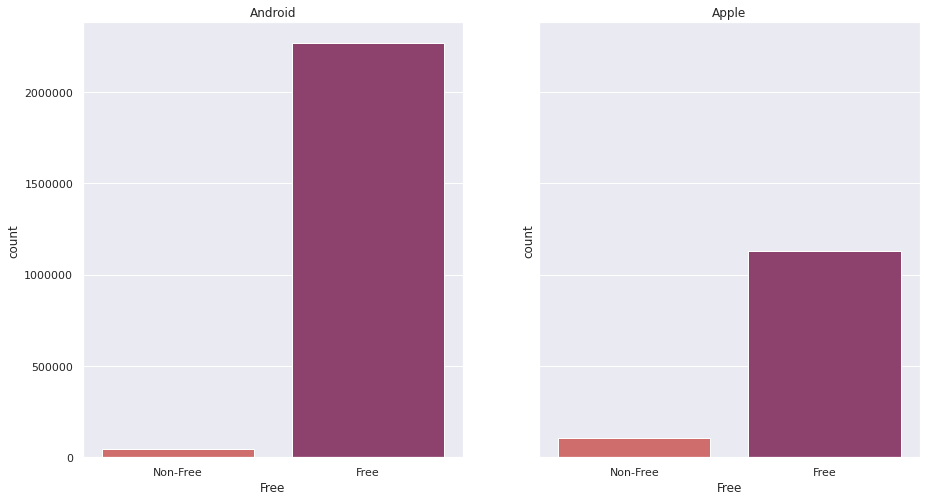

In [61]:
_,ax=plt.subplots(1,2,figsize=(15,8),sharey=True)



g=sns.countplot(ax=ax[0],x='Free',data=df_google,palette='flare')
plt.xticks(rotation=0)
ax[0].ticklabel_format(style='plain', axis='y')
g.set_title("Android")
g.set_xticklabels(['Non-Free','Free'])


g=sns.countplot(x='Free',data=df_apple,palette='flare')
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
g.set_title("Apple")

g.set_xticklabels(['Non-Free','Free'])


plt.show()

## Categories

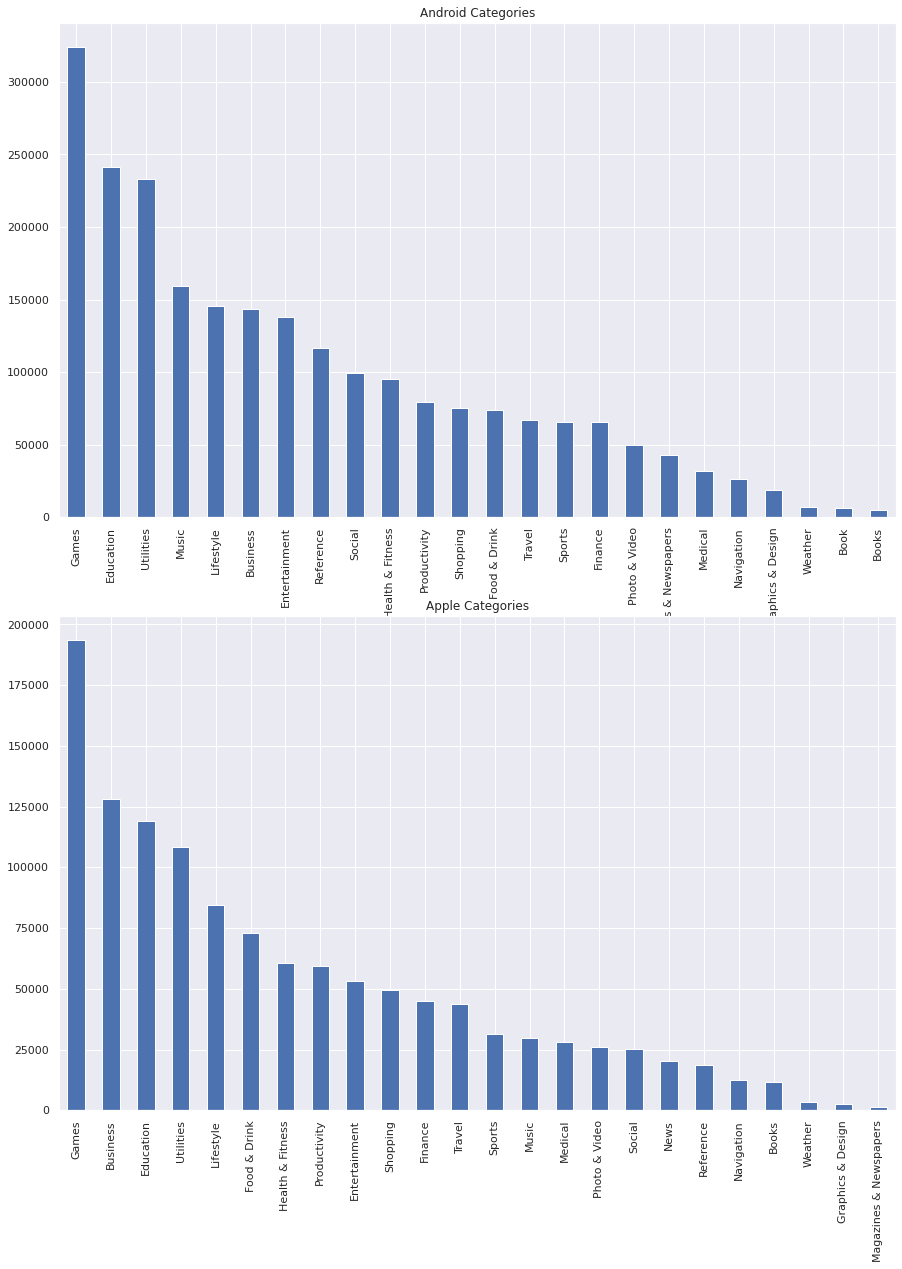

In [84]:
fig,ax=plt.subplots(2,1,figsize=(15,20))

df_google["Category"].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Android Categories')

ax[1].set_title('Apple Categories')
df_apple["Category"].value_counts().plot(kind='bar',ax=ax[1])
plt.show()

# Content Rating

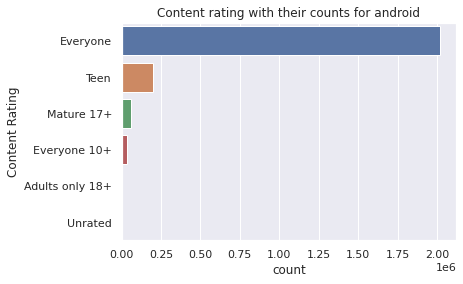

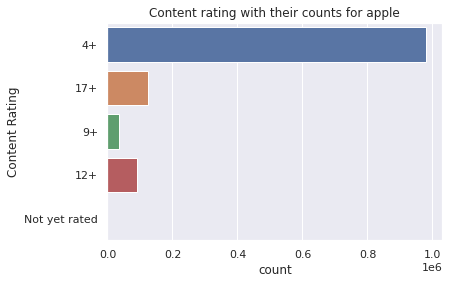

In [25]:
sns.countplot(y = "Content Rating", data = df_google)
plt.title("Content rating with their counts for android")

plt.show()
sns.countplot(y = "Content Rating", data = df_apple)
plt.title("Content rating with their counts for apple")
plt.show()

# Price vs Categories

Text(0.5, 1.0, 'Category & Price (apple)')

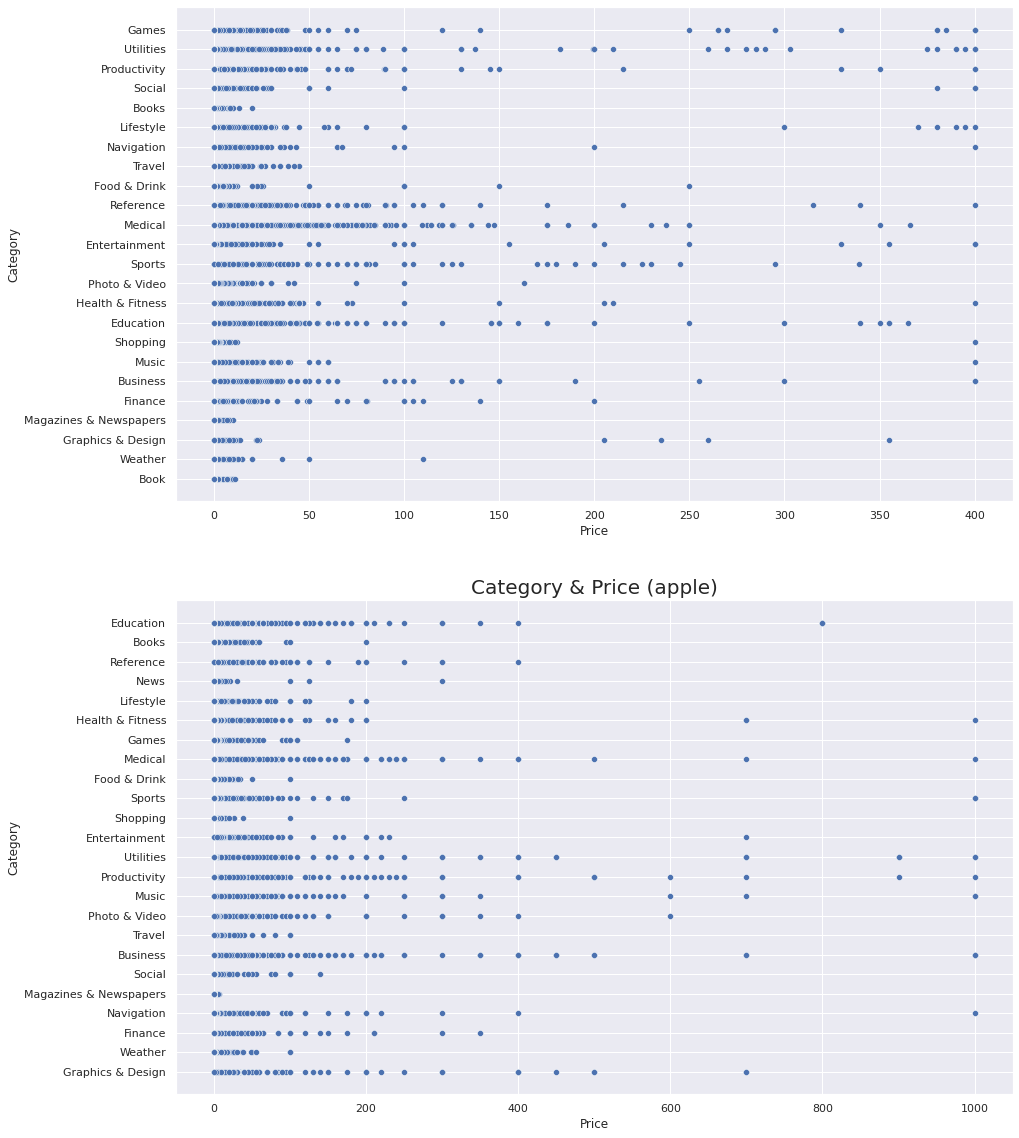

In [33]:
fig,ax=plt.subplots(2,1,figsize=(15,20))

sns.scatterplot(data = df_google, y = "Category", x = "Price",ax=ax[0])
plt.title("Category & Price (android)", size=20)

sns.scatterplot(data = df_apple, y = "Category", x = "Price",ax=ax[1])
plt.title("Category & Price (apple)", size=20)

## Price vs Rating

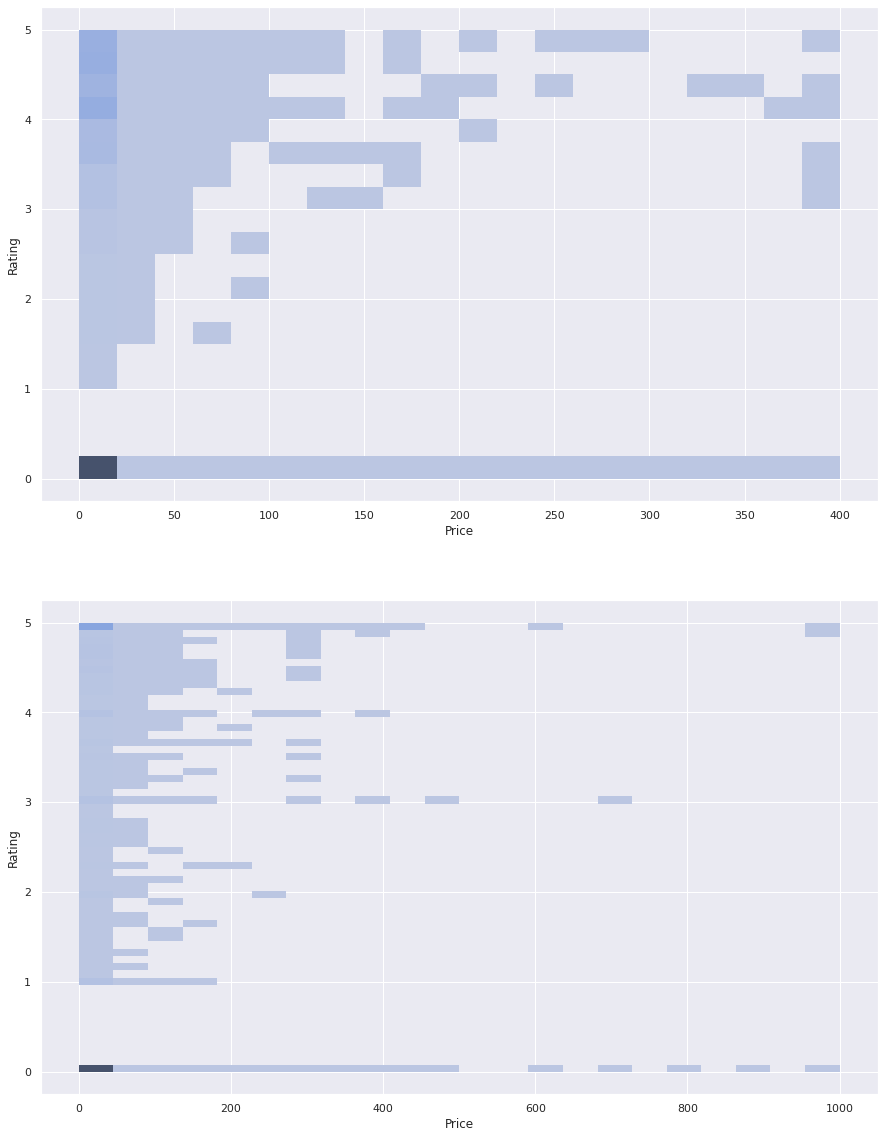

In [112]:
fig,ax=plt.subplots(2,1,figsize=(15,20))


g = sns.histplot(ax=ax[0],x='Price',y='Rating',data=df_google,bins=20)

sns.histplot(x='Price',y='Rating',data=df_apple)

plt.show()


